experiments on fair text generation

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), ".."))

import numpy as np
import torch
from torch.nn import functional
import copy
import matplotlib.pyplot as plt
import os
import json
#from core.GMC import GMC
import h5py
import cv2
from utils.utils import eval, plot_result, eval2
from transformers import AutoTokenizer, BertForPreTraining
from sklearn.model_selection import train_test_split
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertForPreTraining.from_pretrained("bert-base-uncased")

set alpha

In [8]:
alpha = 0.012

load data and split it into train sets, calibration sets and test sets.

In [3]:
data_path = os.path.join(os.getcwd(), '..','datasets/FairText/Result/Result.h')
f = h5py.File(data_path, "r")
position, p,x,y = f['mask'], f['p'], np.array(list(map(lambda x:x.decode(), f['x']))), np.array(f['y'])
data_path_2 = os.path.join(os.getcwd(), '..','datasets/FairText/Result/result.h')
f2 = h5py.File(data_path_2, "r")
position_2, p_2, x_2, y_2 = f2['mask'][:-103], f2['p'][:-103,:,:], np.array(list(map(lambda x:x.decode(), f2['x'])))[:-103], np.array(f2['y'])[:-103]
position,p,x,y = np.concatenate([position, position_2]), np.concatenate([p, p_2]), np.concatenate([x,x_2]),np.concatenate([y, y_2])
print('raw data shape: ', p.shape, len(x), len(y))
p = np.array(p)[[i for i in range(p.shape[0])], np.array(list(position)),:]
p_cal, p_test, x_cal, x_test, y_cal, y_test = train_test_split(p, x, y, test_size=0.3, random_state=16)
print('train shape: ', p_cal.shape[0], 'test shape: ', p_test.shape[0])

raw data shape:  (1097, 29, 30522) 1097 1097
train shape:  767 test shape:  330


In [4]:
accuracy_test_data_path = os.path.join(os.getcwd(), '..','datasets/FairText/Result/Accuracy_test.h')
f2 = h5py.File(accuracy_test_data_path, "r")
position_accu, p_accu, x_accu, y_accu = f2['mask'], f2['p'], np.array(list(map(lambda x:x.decode(), f2['x']))), np.array(f2['y'])
print('raw data shape: ', p_accu.shape, len(x_accu), len(y_accu))
p_accu = np.array(p_accu)[[i for i in range(p_accu.shape[0])], np.array(list(position_accu)),:]

raw data shape:  (600, 29, 30522) 600 600


In [5]:
indicator_path = {'female':"datasets/FairText/Data/female-word.txt", 'male':"datasets/FairText/Data/male-word.txt",
            'well_profession':"datasets/FairText/Data/male-related occupations.txt", 
            'less_profession':"datasets/FairText/Data/female-related occupations.txt",
            'pleasant':"datasets/FairText/Data/pleasant-adj.txt", 'unpleasant':"datasets/FairText/Data/unpleasant-adj.txt",
            'female-adj':"datasets/FairText/Data/female-adj.txt", 'male-adj':"datasets/FairText/Data/male-adj.txt"}
indicator = {}
for key in indicator_path:
    f = open(os.path.join('..', indicator_path[key]),'r', encoding='gb2312', errors='ignore').readlines()
    indicator[key] = list(map(lambda s:s[:-1], f))

set sensitive subgroups

In [6]:
def intersect_or_not(a,b):
    # input two lists; return whether they intersect
    return len(list(set(a)&set(b)))!=0


def generate_sensitive_vector(mark, total_length=30522):
    # input a list of the position of 1; output an indicator function of it; to one hot
    vec = np.zeros(total_length)
    for position in mark:
        vec[tokenizer(position).input_ids[1]] = 1
    return vec


def generate_G():
    female = lambda x:intersect_or_not(x.split(' '), indicator['female'])
    male = lambda x:intersect_or_not(x.split(' '), indicator['male'])
    vec_list = [generate_sensitive_vector(subgroup) for subgroup in [indicator['female-adj'],indicator['male-adj'],
                indicator['less_profession'], indicator['well_profession'], indicator['pleasant'], indicator['unpleasant']]]
    G = []
    G.append(lambda x:vec_list[0]*female(x))
    G.append(lambda x:vec_list[0]*male(x))
    G.append(lambda x:-vec_list[0]*female(x))
    G.append(lambda x:-vec_list[0]*male(x))  
    G.append(lambda x:vec_list[1]*female(x))
    G.append(lambda x:vec_list[1]*male(x))
    G.append(lambda x:-vec_list[1]*female(x))
    G.append(lambda x:-vec_list[1]*male(x))  
    G.append(lambda x:vec_list[2]*female(x))
    G.append(lambda x:vec_list[2]*male(x))
    G.append(lambda x:-vec_list[2]*female(x))
    G.append(lambda x:-vec_list[2]*male(x))    
    G.append(lambda x:vec_list[3]*female(x))
    G.append(lambda x:vec_list[3]*male(x))
    G.append(lambda x:-vec_list[3]*female(x))
    G.append(lambda x:-vec_list[3]*male(x))
    G.append(lambda x:vec_list[4]*female(x))
    G.append(lambda x:vec_list[4]*male(x))
    G.append(lambda x:-vec_list[4]*female(x))
    G.append(lambda x:-vec_list[4]*male(x))  
    G.append(lambda x:vec_list[5]*female(x))
    G.append(lambda x:vec_list[5]*male(x))
    G.append(lambda x:-vec_list[5]*female(x))
    G.append(lambda x:-vec_list[5]*male(x))   
    return G


def projection(f):
    # input a vector, project it into a vector with means 0
    return f-np.mean(f)


G = generate_G()

def s(f, x, y, p):
    return f+p-average_p

run

In [20]:
import copy

def GMC(alpha, eta, x_cal, y_cal, h_cal, x_test, h_test, s, group_G, f=(lambda x:0), f_test=(lambda x:0), T=500, proj=None):
    '''
    eta:learning_rate
    x_cal:numpy
    y_cal:numpy
    h_cal:numpy
    x_test:numpy
    h_test:numpy
    s:mapping_function
    f:initial_function 
    group_G:list of group functions
    T:max_iteration
    return function f
    ''' 
    fx = f(x_cal)
    fx_test = f_test(x_test)
    n = x_cal.shape[0]
    for i in range(T):
        update = False
        for g in group_G:
            gx = np.array([g(x1)for x1 in x_cal])
            if np.sum(np.diagonal(gx@(s(fx, x_cal, y_cal, h_cal).T)))>alpha*n:
                update = True
                print(group_G.index(g))
                break
        if update==False:
            print(i)
            print('end')
            return i, fx, fx_test
        else:
            gx_test = np.array([g(x1)for x1 in x_test])
            fx = fx - eta*gx
            fx_test = fx_test - eta*gx_test
            if not (proj is None):
                fx = proj(fx)
                fx_test = proj(fx_test)
    return i+1, fx, fx_test

def eval(G, s, fx, x_cal, y_cal, h_cal, accu=False):
    S = []
    n = x_cal.shape[0]
    if accu:
        return np.sum(s(fx, x_cal, y_cal, h_cal))/n
    for g in G:
        gx = np.array([g(x1)for x1 in x_cal])
        S.append(np.sum(np.diagonal(gx@(s(fx, x_cal, y_cal, h_cal).T)))/n)
    return np.array(S)

alpha = 0.01
eta = 0.001
vocab = 30522
fx = np.zeros(vocab)
fx_test = np.zeros(vocab)
for i in range(30):
    average_p = np.mean(p_cal+fx,axis=0)
    j, fx, fx_test = GMC(3/4*alpha, eta, x_cal, y_cal, p_cal, x_test, p_test, s, G, f=(lambda x:fx), f_test=(lambda x:fx_test), T=1, proj = projection)
    if j==0:
        break

1
6
6
7
13
13
0
end


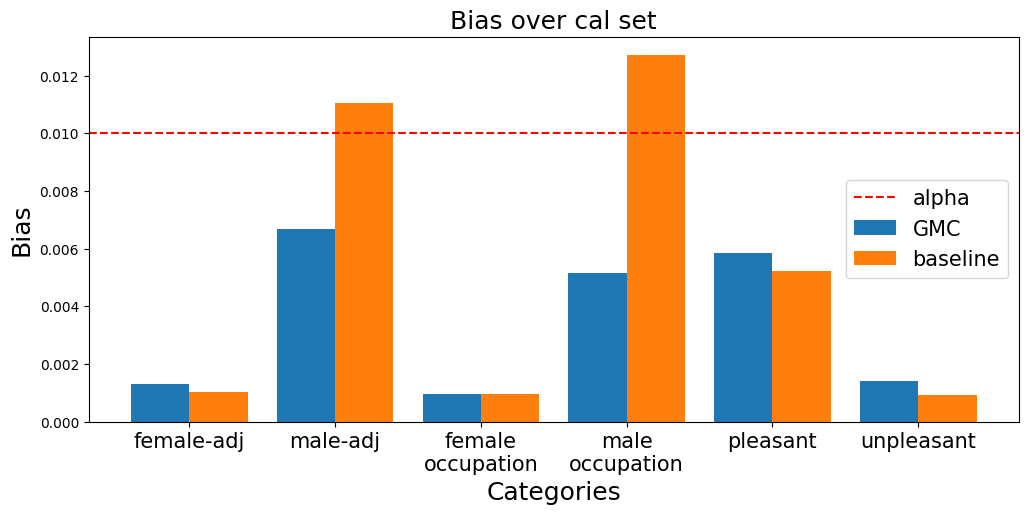

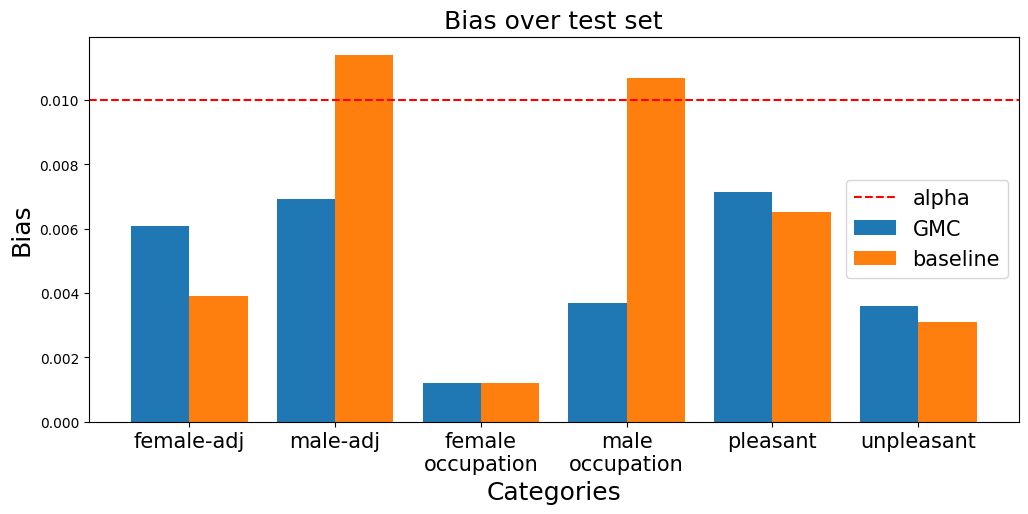

In [22]:
category = ['female-adj', 'male-adj', 'female\noccupation', 'male\noccupation', 'pleasant', 'unpleasant']
select_G = [G[0], G[4], G[8], G[12], G[16], G[20]]
average_p = np.mean(p_cal+fx,axis=0)
gap_cal = eval(select_G, s, fx, x_cal, y_cal, p_cal)
average_p = np.mean(p_cal,axis=0)
gap_cal_b = eval(select_G, s, 0, x_cal, y_cal, p_cal)
average_p = np.mean(p_test+fx_test,axis=0)
gap_test = eval(select_G, s, fx_test, x_test, y_test, p_test)
average_p = np.mean(p_test,axis=0)
gap_test_b = eval(select_G, s, 0, x_test, y_test, p_test)
gap_cal, gap_cal_b, gap_test, gap_test_b = abs(gap_cal), abs(gap_cal_b), abs(gap_test), abs(gap_test_b) 
plot_result(category, gap_cal, gap_cal_b, 'Categories', 'Bias', 'Bias over cal set', base=alpha)
plot_result(category, gap_test, gap_test_b, 'Categories', 'Bias', 'Bias over test set', base=alpha)

In [11]:
eta = 0.002
vocab = 30522
fx = np.zeros(vocab)
fx_accu = np.zeros(vocab)
for i in range(30):
    average_p = np.mean(p_cal+fx,axis=0)
    #print(np.sum(average_p))
    j, fx, fx_accu = GMC(3/4*alpha, eta, x_cal, y_cal, p_cal, x_accu, p_accu, s, G, f=(lambda x:fx), f_test=(lambda x:fx_accu), T=1, proj = projection)
    if j==0:
        break
    #print(np.sum(np.abs(average_p-np.mean(p+fx,axis=0))))

6
7
13
0
end


In [12]:
import torch.nn.functional as F
def entropy(f, x, y, p):
    return F.cross_entropy(torch.Tensor(f+p),torch.Tensor(y).long()).numpy()*p.shape[0]
G_accu = [lambda x,f:1]
accu = eval(G_accu, entropy, fx_accu, x_accu, y_accu, p_accu, accu=True)
accu_b = eval(G_accu, entropy, 0, x_accu, y_accu, p_accu, accu=True)
print('cross entropy of our algorithm: ', accu)
print('cross entropy of the baseline: ', accu_b)

cross entropy of our algorithm:  9.598319053649902
cross entropy of the baseline:  9.598318099975586
